In [0]:
try:
  # Use the %tensorflow_version magic if in colab.
  %tensorflow_version 2.x
except Exception:
  pass

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
keras = tf.keras


In [0]:
# Methods to draw the time series
def plot_series(time, series, format="-", start=0, end=None, label=None):
    plt.plot(time[start:end], series[start:end], format, label=label)
    plt.xlabel("Time")
    plt.ylabel("Value")
    if label:
        plt.legend(fontsize=14)
    plt.grid(True)
    
# for trend
def trend(time, slope=0):
    return slope * time

def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))
# for seasonality  
def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

#for noise 
def white_noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

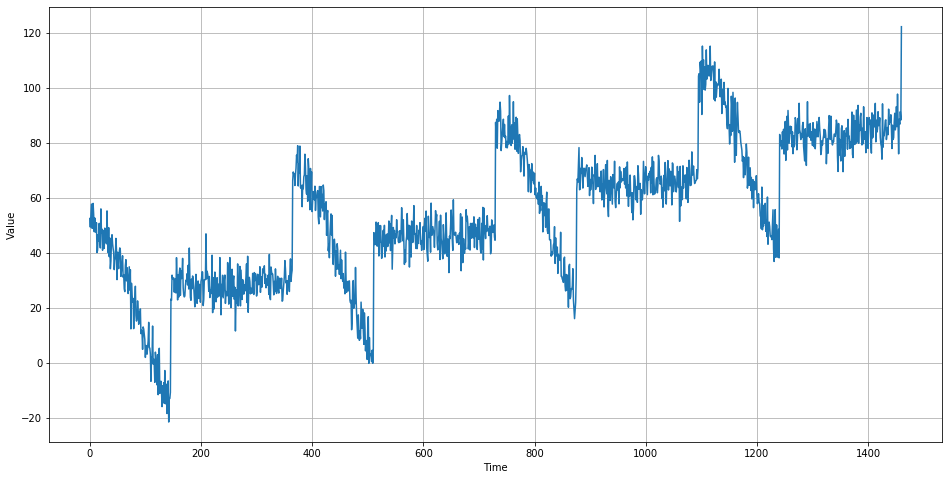

In [52]:
# Trend + Seasonality 
time = np.arange(4 * 365 + 1)

slope = 0.05
baseline = 10
amplitude = 40
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)

noise_level = 5
noise = white_noise(time, noise_level, seed=42)

series += noise

plt.figure(figsize=(16, 8))
plot_series(time, series)
plt.show()

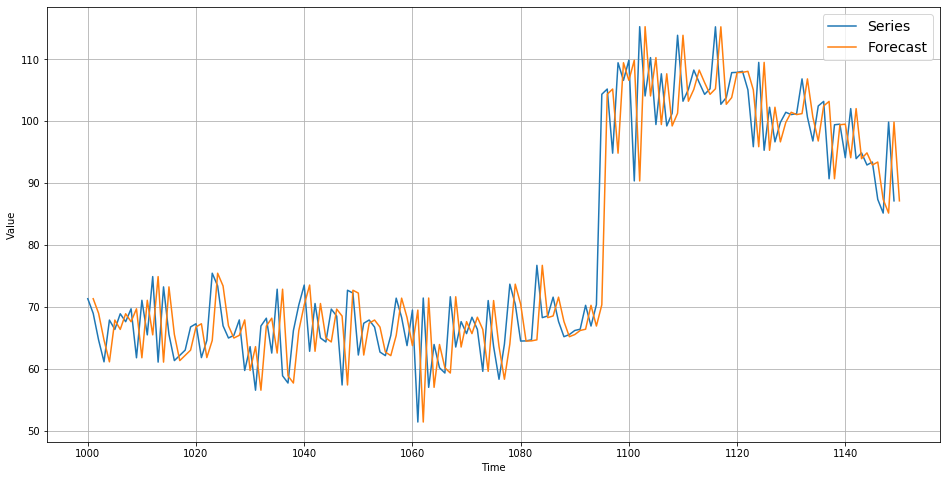

In [53]:
# Naive Forcasting 
split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

naive_forecast = series[split_time - 1:-1]

plt.figure(figsize=(16, 8))
plot_series(time_valid, x_valid, start=0, end=150, label="Series")
plot_series(time_valid, naive_forecast, start=1, end=151, label="Forecast")

In [54]:
# Using keras.metrics to compute MAE between the forcasts and the predictions in the validation period.
keras.metrics.mean_absolute_error(x_valid,naive_forecast).numpy()


5.937908515321673

In [55]:
# Using keras.metrics to compute MSE between the forcasts and the predictions in the validation period.
keras.metrics.mean_squared_error(x_valid,naive_forecast).numpy()

61.82753366856371

## Moving Average 

In [0]:
# forcasts the mean of the last few values.
# window _size = 1, then this is equivalent to navie forecast 

def moving_average_forecast(series, window_size):
  forcast = []
  for time in range(len(series) - window_size):
    forecast.append(series[time:time + window_size].mean())
  return np.array(forecast)


In [0]:
# forcasts the mean of the last few values.
# window _size = 1, then this is equivalent to navie forecast 
# this implemenntation is much faster than the pervious one

def moving_average_forecast(series, window_size):
  mov = np.cumsum(series)
  mov[window_size:] =  mov[window_size:] - mov[:-window_size]
  return mov[window_size -1:-1] / window_size

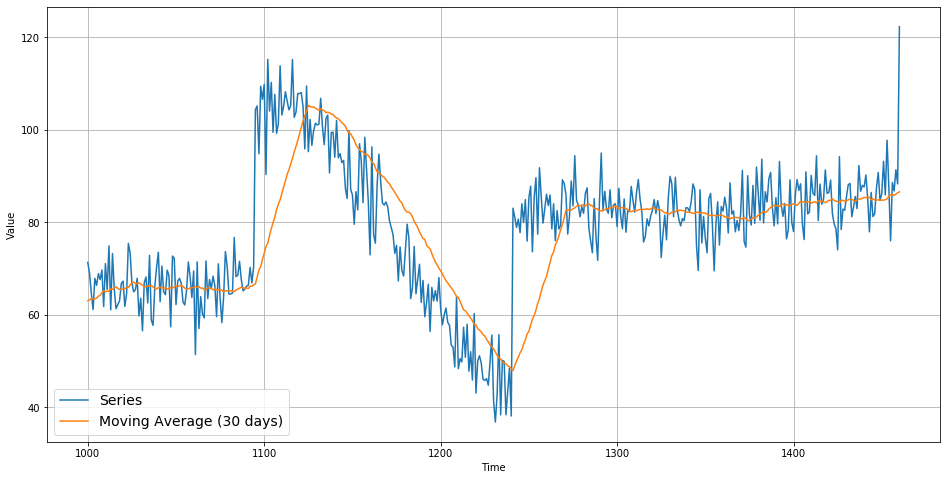

In [58]:
moving_avg = moving_average_forecast(series, 30 )[split_time -30:]

plt.figure(figsize=(16,8))
plot_series(time_valid, x_valid, label="Series")
plot_series(time_valid,moving_avg, label="Moving Average (30 days)")


In [59]:
# Using keras.metrics to compute MAE between the moving average forcasts and the predictions in the validation period.
keras.metrics.mean_absolute_error(x_valid,moving_avg).numpy()

7.142418570620783

MAE got worse for the moving average as compared to the naive forcast. 

The moving average does not anticipate trend or seasonality, so let's try to remove them by differencing. 

Since the seasonality period is 365 days, we will substract the value at 
time t- 365 from the value at time t.

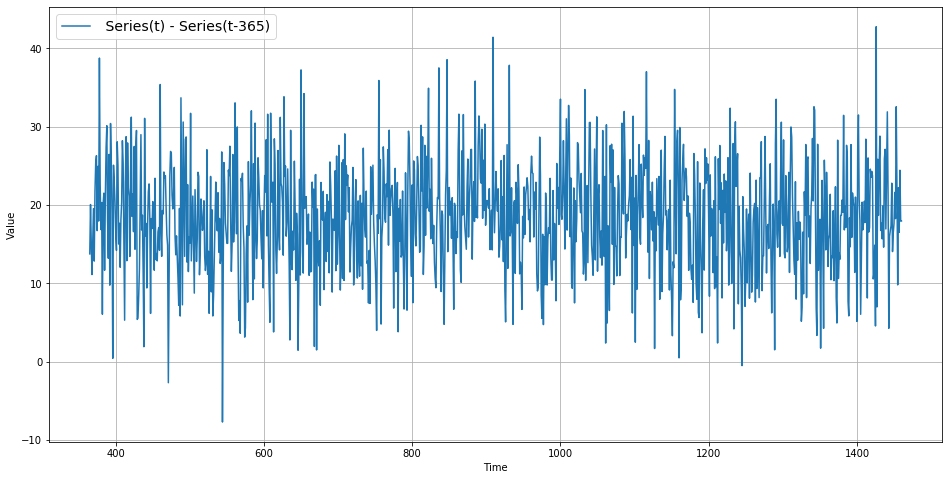

In [60]:
diff_series = (series[365:] - series[:-365])
diff_time = time[365:]

plt.figure(figsize=(16,8))
plot_series(diff_time, diff_series , label=" Series(t) - Series(t-365)")
plt.show()

 Focusing only on the validation period

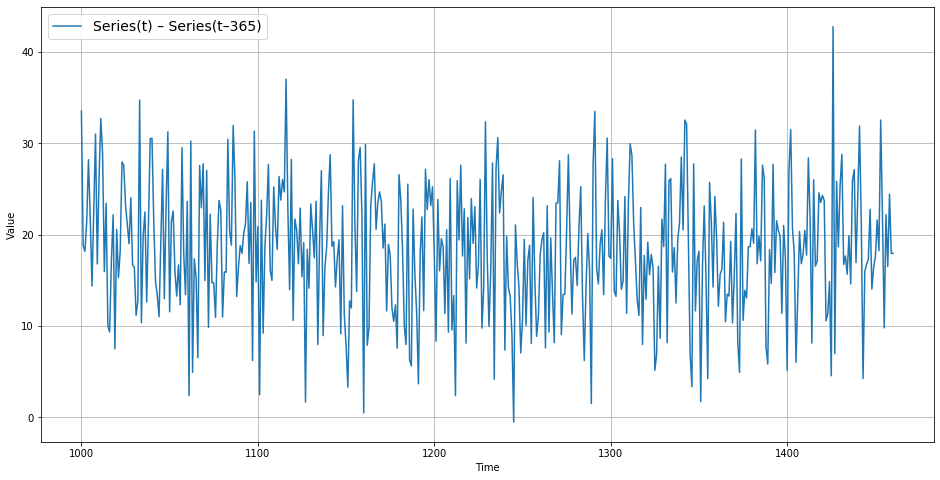

In [61]:
plt.figure(figsize=(16, 8))
plot_series(time_valid, diff_series[split_time - 365:], label="Series(t) – Series(t–365)")
plt.show()

We can now use the moving average, as trend and seasonality seem to be gone.

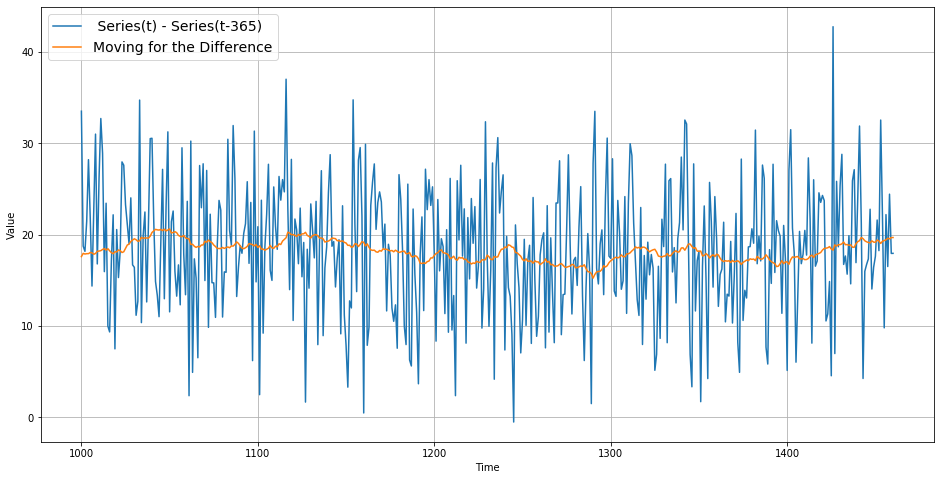

In [62]:
diff_moving_average = moving_average_forecast(diff_series, 50)[split_time -365 -50: ]
plt.figure(figsize=(16,8))

plot_series(time_valid, diff_series[split_time - 365: ], label=" Series(t) - Series(t-365)")
plot_series(time_valid, diff_moving_average, label="Moving for the Difference")
plt.show()

Now lets introduce trend and seasonality by adding the past values from t-365:

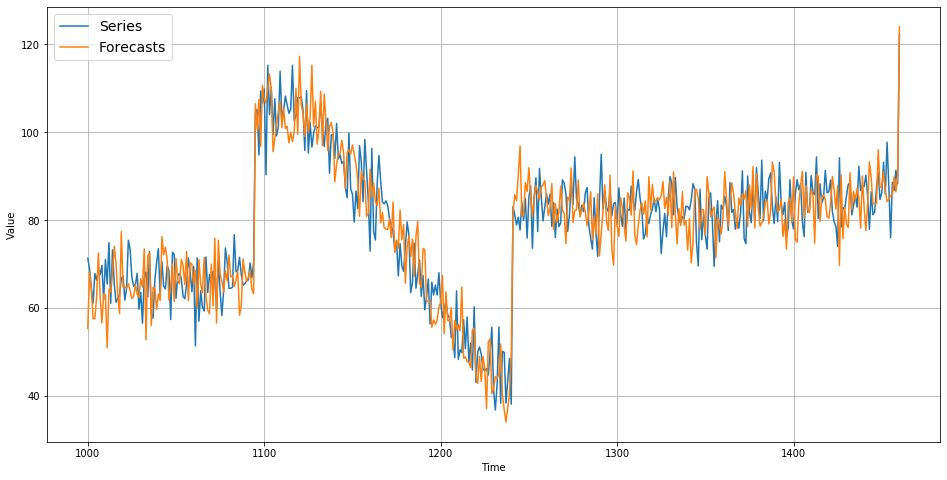

In [63]:
diff_moving_avg_plus_past = series[split_time - 365: -365] + diff_moving_average
plt.figure(figsize=(16,8))

plot_series(time_valid, x_valid, label="Series")
plot_series(time_valid, diff_moving_avg_plus_past,label="Forecasts")
plt.show()

In [64]:
# Using keras.metrics to compute MAE between the moving average forcasts and the predictions in the validation period.
keras.metrics.mean_absolute_error(x_valid,diff_moving_avg_plus_past).numpy()

5.8393105629958955

Good !! this is better than navie forecast.

The forcast looks a bit random because we added past values, which were noisy. 

Now, let's use a moving average on the past values to remove some of the noise. 

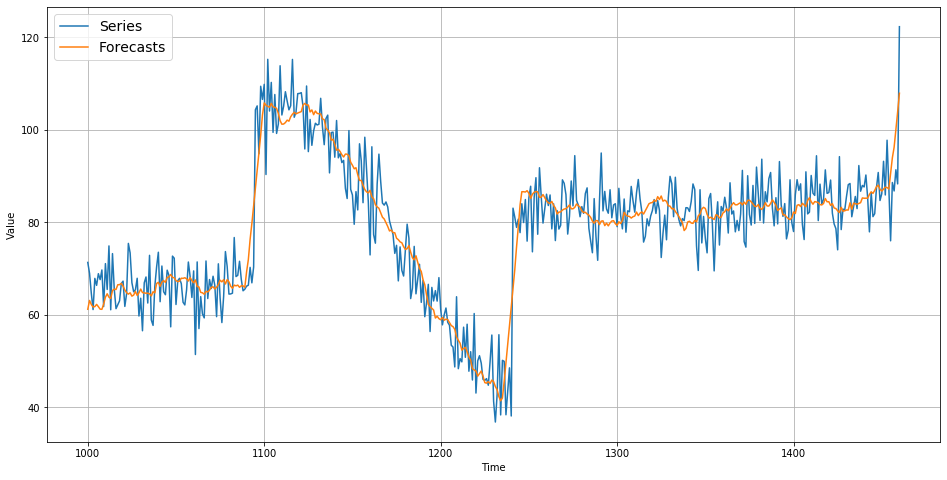

In [65]:
diff_moving_avg_plus_smooth_past = moving_average_forecast(series[split_time - 370: - 359], 11 ) + diff_moving_average

plt.figure(figsize=(16,8))
plot_series(time_valid,x_valid, label="Series")
plot_series(time_valid, diff_moving_avg_plus_smooth_past, label="Forecasts")
plt.show()

In [66]:
# Using keras.metrics to compute MAE between the moving average forcasts and the predictions in the validation period.
keras.metrics.mean_absolute_error(x_valid,diff_moving_avg_plus_smooth_past).numpy()

4.566859958970772

Looks pretty good !! => Apply Machine Learning model to this.